In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import glob
path = 'data/final/train/'
all_files = glob.glob(path + '*.csv')
# list to append csvs
l = []
# loop over all files
for filename in all_files:
    df_tmp = pd.read_csv(filename, index_col=None, header=0)
    l.append(df_tmp)

# Add all data frames together
df = pd.concat(l, axis=0, ignore_index=True)

In [3]:
# turn result to dummies
d = {'successful': 1, 'failed': 0}
df.state = [d[i] for i in df.state]
y_model = df.state

# Word importances
Use multinomial Naive Bayes to find most important words to predict states!\
Do this by lookin at P(term | class) = P(term | in class) - P(term | not in class)
## Single word importances

In [4]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer

blurbs = df['blurb'].values
# number of times the words have to occur at least
min_df=600

# ngram_range only use 1 word, stop_words=english remove common words(eg: a, an, the)
# CountVectorizer ignores difference between lower and upper case and puncuation
vect = CountVectorizer(ngram_range=(1,1), stop_words='english', min_df=min_df)

# CountVectorizer converts list of strings to matrix with: rows = observation, columns = terms in text, values=count/document
X = vect.fit_transform(blurbs)
words = vect.get_feature_names()

y = df['state'].values

# remove alpha to prevent bias
clf = MultinomialNB(alpha=1.e-10)
clf.fit(X,y)

likelihood_df = pd.DataFrame(clf.feature_log_prob_.transpose(),columns=['failed', 'success'], index=words)

In [5]:
likelihood_df['Relative Prevalence for Relief'] = likelihood_df.eval('(exp(success) - exp(failed))')

top_10 = likelihood_df['Relative Prevalence for Relief'].sort_values(ascending=False)[:10]

#Double-sorting here so that the graph will look nicer
bottom_10 = likelihood_df['Relative Prevalence for Relief'].sort_values()[:10].sort_values(ascending=False)

top_and_bottom = pd.concat([top_10,bottom_10])
print("Number of words {}".format(likelihood_df.shape[0]))

Number of words 477


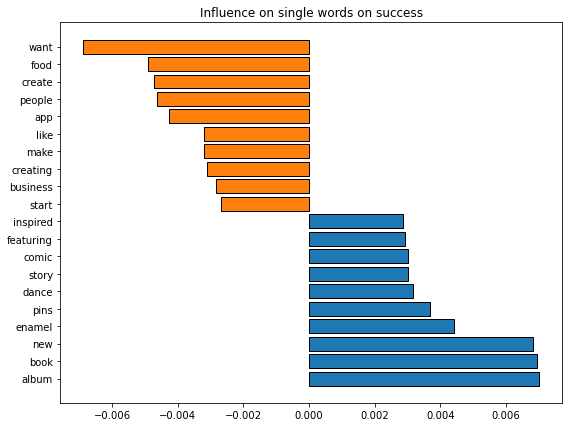

In [6]:
x = range(10)
fig = plt.figure(figsize=(9,7))
ax = plt.subplot(111)
ax.barh(top_10.index, top_10, edgecolor='black')
ax.barh(bottom_10.index,bottom_10, edgecolor='black');
ax.set_title('Influence on single words on success');

# linked word importances
Look at pairs of words now.

In [7]:
blurbs = df['blurb'].values

#ngram_range now use word pairs
vect = CountVectorizer(ngram_range=(2,2), stop_words='english', min_df=min_df)

X = vect.fit_transform(blurbs)
words = vect.get_feature_names()

y = df['state'].values

# remove alpha to prevent bias
clf = MultinomialNB(alpha=1.e-10)
clf.fit(X,y)

likelihood_df_pairs = pd.DataFrame(clf.feature_log_prob_.transpose(),columns=['failed', 'success'], index=words)

In [8]:
likelihood_df_pairs['Relative Prevalence for Relief'] = likelihood_df_pairs.eval('(exp(success) - exp(failed))')

top_10 = likelihood_df_pairs['Relative Prevalence for Relief'].sort_values(ascending=False)[:10]

#Double-sorting here so that the graph will look nicer
bottom_10 = likelihood_df_pairs['Relative Prevalence for Relief'].sort_values()[:10].sort_values(ascending=False)

top_and_bottom_pairs = pd.concat([top_10,bottom_10])

Text(0.5, 1.0, 'Influence on pair words on success')

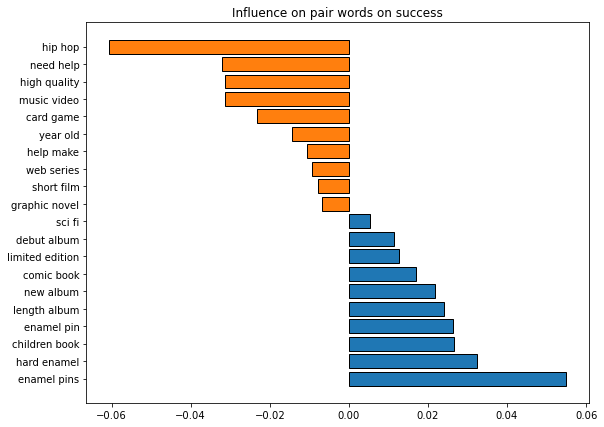

In [9]:
x = range(10)
fig = plt.figure(figsize=(9,7))
ax = plt.subplot(111)
ax.barh(top_10.index, top_10, edgecolor='black')
ax.barh(bottom_10.index,bottom_10, edgecolor='black');
ax.set_title('Influence on pair words on success')

In [10]:
# Create dict of single and pair values
word_rate = top_and_bottom.to_dict()
word_rate.update(top_and_bottom_pairs.to_dict())
#word_rate

# Add feature blurb rating
Add a new feature blurb_rating to the dataframe, that rates the blurb by summarizing rates of all important words and word pairs. 

In [11]:
"""# Single word vectorizer
vect1 = CountVectorizer(ngram_range=(1,1), stop_words='english')
# Pair word vectorizer
vect2 = CountVectorizer(ngram_range=(2,2), stop_words='english')

rates = []
blurbs = df.blurb.values
# Loop over all blurbs
for blurb in blurbs:
    blurb = [blurb]
    # Need to try, because some texts with all words outsorted give value error
    try:
        vect1.fit(blurb)
        vect2.fit(blurb)
        features = vect1.get_feature_names() + vect2.get_feature_names()
    except:
        features = [" "]
    rate=0
    for feature in features:
        if feature in word_rate:
            rate += word_rate[feature]
    rates.append(rate)
df['blurb_rate'] = rates"""

'# Single word vectorizer\nvect1 = CountVectorizer(ngram_range=(1,1), stop_words=\'english\')\n# Pair word vectorizer\nvect2 = CountVectorizer(ngram_range=(2,2), stop_words=\'english\')\n\nrates = []\nblurbs = df.blurb.values\n# Loop over all blurbs\nfor blurb in blurbs:\n    blurb = [blurb]\n    # Need to try, because some texts with all words outsorted give value error\n    try:\n        vect1.fit(blurb)\n        vect2.fit(blurb)\n        features = vect1.get_feature_names() + vect2.get_feature_names()\n    except:\n        features = [" "]\n    rate=0\n    for feature in features:\n        if feature in word_rate:\n            rate += word_rate[feature]\n    rates.append(rate)\ndf[\'blurb_rate\'] = rates'

In [12]:
df.head(3)

,backers_count,blurb,category,country,currency,slug,staff_pick,state,usd_pledged,usd_type,goal_usd,word_count,month_launched,days_running
0,0,a new website where people can found their spe...,technology,IT,EUR,wanna-eat,False,0,0.000000,international,11202.86260,24,9,60
1,43,"An online magazine for men, promoting a more i...",journalism,GB,GBP,u-zine-the-inclusive-zine-for-men,True,0,1165.285512,international,14434.84306,14,8,40
2,4,"We need your help to get the new album ready, ...",music,US,USD,new-epmerch-and-tour,False,0,87.000000,domestic,5000.00000,25,7,60


# Adaboost without blurb rate

In [13]:
# Create column category_rate
total = df.category.value_counts(sort=False)
success = df.query('state == 1').category.value_counts(sort=False)
category_to_rate = dict(success/total)
df['category_rate'] = [category_to_rate[i] for i in df.category]

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [15]:
X_model = df[['goal_usd', 'category_rate', 'days_running', 'word_count']]
X_model = MinMaxScaler().fit_transform(X_model)
y_model = df.state

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X_model, y_model, random_state=1, test_size=0.3)

In [17]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.metrics import accuracy_score, f1_score

clf = AdaBoostClassifier()
params = {'n_estimators': [50]}
adb = GridSearchCV(clf, cv=5, param_grid=params, scoring="f1", n_jobs=-1)
adb.fit(X_train, y_train)
#adb.fit(X_train, y_train)
#cv_result = cross_validate(adb, X_train, y_train, cv=5, scoring="f1")
#cv_result['test_score'].mean()

GridSearchCV(cv=5, estimator=AdaBoostClassifier(), n_jobs=-1,
             param_grid={'n_estimators': [50]}, scoring='f1')

In [18]:
y_pred = adb.predict(X_test)
method_result = pd.DataFrame({'metric': ['accuracy', 'f1-score'],
                          'adb_no_blurb': [accuracy_score(y_test, y_pred).round(2), f1_score(y_test, y_pred, pos_label=1).round(2)]})
method_result

,metric,adb_no_blurb
0,accuracy,0.69
1,f1-score,0.77


# Ada boost with multiple blurb words/pairs

In [19]:
def get_dict(likelihood_df, likelihood_df_pairs, num_words):
    
    # get top and bottom words with count num_words
    top = likelihood_df['Relative Prevalence for Relief'].sort_values(ascending=False)[:num_words]
    bottom = likelihood_df['Relative Prevalence for Relief'].sort_values()[:num_words]
    top_pairs = likelihood_df_pairs['Relative Prevalence for Relief'].sort_values(ascending=False)[:num_words]
    bottom_pairs = likelihood_df_pairs['Relative Prevalence for Relief'].sort_values()[:num_words]
    top_and_bottom = pd.concat([top,bottom])
    top_and_bottom_pairs = pd.concat([top_pairs, bottom_pairs])

    # Create dict of single and pair values
    word_rate = top_and_bottom.to_dict()
    #word_rate.update(top_and_bottom_pairs.to_dict())
    
    return word_rate

In [20]:
## Add blurb_rates to data frame df
def add_blurb_rate(df, word_rate):
    
    # Single word vectorizer
    vect1 = CountVectorizer(ngram_range=(1,1), stop_words='english')
    # Pair word vectorizer
    vect2 = CountVectorizer(ngram_range=(2,2), stop_words='english')

    rates = []
    blurbs = df.blurb.values
    # Loop over all blurbs
    for blurb in blurbs:
        blurb = [blurb]
        # Need to try, because some texts with all words outsorted give value error
        try:
            vect1.fit(blurb)
            vect2.fit(blurb)
            features = vect1.get_feature_names() + vect2.get_feature_names()
        except:
            features = ["xxxxxxxxxxxxxx"]
        rate=0
        for feature in features:
            if feature in word_rate:
                rate += word_rate[feature]
        rates.append(rate)
    df['blurb_rate'] = rates
    
    return df

In [21]:
clf = AdaBoostClassifier()
params = {'n_estimators': [50]}
adb = GridSearchCV(clf, cv=5, param_grid=params, scoring="f1", n_jobs=-1)
for num_words in [10, 50, 100]:
    word_rate = get_dict(likelihood_df, likelihood_df_pairs, num_words)
    df = add_blurb_rate(df, word_rate)
    
    X_model = df[['goal_usd', 'category_rate', 'days_running', 'word_count', 'blurb_rate']]
    X_model = MinMaxScaler().fit_transform(X_model)
    y_model = df.state
    X_train, X_test, y_train, y_test = train_test_split(X_model, y_model, random_state=1, test_size=0.3)
    
    adb.fit(X_train, y_train)
    y_pred = adb.predict(X_test)
    method_result['adb_words_' + str(num_words)] = [accuracy_score(y_test, y_pred).round(2), f1_score(y_test, y_pred, pos_label=1).round(2)]
    print(method_result)

     metric  adb_no_blurb  adb_words_10
0  accuracy          0.69          0.70
1  f1-score          0.77          0.77
     metric  adb_no_blurb  adb_words_10  adb_words_50
0  accuracy          0.69          0.70          0.70
1  f1-score          0.77          0.77          0.77
     metric  adb_no_blurb  adb_words_10  adb_words_50  adb_words_100
0  accuracy          0.69          0.70          0.70           0.70
1  f1-score          0.77          0.77          0.77           0.78


# Same with Decision tree

In [22]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(class_weight='balanced', criterion='entropy', min_samples_split= 20, splitter= 'best')
params = {'max_depth': [6]}
model = GridSearchCV(clf, cv=5, param_grid=params, scoring="f1", n_jobs=-1)

In [23]:
for num_words in [10, 50, 100]:
    word_rate = get_dict(likelihood_df, likelihood_df_pairs, num_words)
    df = add_blurb_rate(df, word_rate)
    
    X_model = df[['goal_usd', 'category_rate', 'days_running', 'word_count', 'blurb_rate']]
    X_model = MinMaxScaler().fit_transform(X_model)
    y_model = df.state
    X_train, X_test, y_train, y_test = train_test_split(X_model, y_model, random_state=1, test_size=0.3)
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    method_result['tree_words_' + str(num_words)] = [accuracy_score(y_test, y_pred).round(2), f1_score(y_test, y_pred, pos_label=1).round(2)]
    print(method_result)

     metric  adb_no_blurb  adb_words_10  adb_words_50  adb_words_100  \
0  accuracy          0.69          0.70          0.70           0.70   
1  f1-score          0.77          0.77          0.77           0.78   

   tree_words_10  
0           0.67  
1           0.72  
     metric  adb_no_blurb  adb_words_10  adb_words_50  adb_words_100  \
0  accuracy          0.69          0.70          0.70           0.70   
1  f1-score          0.77          0.77          0.77           0.78   

   tree_words_10  tree_words_50  
0           0.67           0.68  
1           0.72           0.73  
     metric  adb_no_blurb  adb_words_10  adb_words_50  adb_words_100  \
0  accuracy          0.69          0.70          0.70           0.70   
1  f1-score          0.77          0.77          0.77           0.78   

   tree_words_10  tree_words_50  tree_words_100  
0           0.67           0.68            0.67  
1           0.72           0.73            0.73  


In [24]:
method_result

,metric,adb_no_blurb,adb_words_10,adb_words_50,adb_words_100,tree_words_10,tree_words_50,tree_words_100
0,accuracy,0.69,0.70,0.70,0.70,0.67,0.68,0.67
1,f1-score,0.77,0.77,0.77,0.78,0.72,0.73,0.73


Model is __not improved__ by word analysis...